In [2]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline
import sys
print(sys.version)


from qiskit import pulse, QuantumCircuit, ClassicalRegister#, IBMQ

from qiskit_ibm_runtime import QiskitRuntimeService

#from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional


# IBMQ.save_account("TOKEN", overwrite=True)
# Run previous line with the appropriate token
# service = QiskitRuntimeService(channel="ibm_cloud", token="TOKEN", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/b500a23b61df4c36a9f1eef14a04227d:a6e2883a-5882-4f71-9942-1e480bb96768::")
service = QiskitRuntimeService()
print(service)

3.9.11 (v3.9.11:2de452f8bf, Mar 16 2022, 10:34:36) 
[Clang 6.0 (clang-600.0.57)]
<QiskitRuntimeService>


In [3]:
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# provider.backends()
### SHERBROOKE DETAILS ###
backend = service.backend('ibm_sherbrooke') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 0
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [4]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7ff3984500d0>
backend_name
ibm_sherbrooke
backend_version
1.5.5
n_qubits
127
basis_gates
['ecr', 'id', 'rz', 'sx', 'x']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], 

## Running an Acquisition Scan with a Rough Reset Pulse, analysing plot

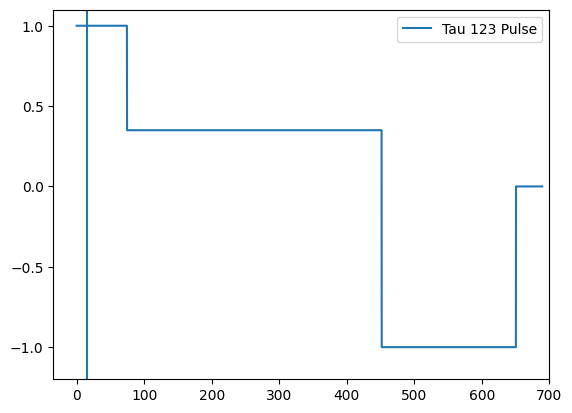

In [5]:
from utils import convert_arr_to_dt, get_dt_from

cal_tau_1 = 75 * ns
cal_tau_2 = 450 * ns
long_tau_3 = 200.0 * ns

meas_pulse_dur_dt = get_dt_from(cal_tau_2 + long_tau_3 + 40. * ns)

def get_tau_123_waveform(tau_1_dur_dt, tau_2_dur_dt, tau_3_dur_dt, total_dur_dt):
    t123_times = np.arange(total_dur_dt) * dt
    tau_123_pulse = measure_pulse.amp * np.heaviside(t123_times - tau_1_dur_dt * dt, 1.) * np.heaviside(tau_2_dur_dt * dt - t123_times, 1.)
    tau_123_pulse += np.heaviside(tau_1_dur_dt * dt - t123_times, 0.) # add tau 1 ring-up
    tau_123_pulse -= np.heaviside((tau_2_dur_dt + tau_3_dur_dt) * dt - t123_times, 0.) * np.heaviside(t123_times - (tau_2_dur_dt) * dt, 0.)
    return tau_123_pulse

tau_123_pulse = get_tau_123_waveform(
    get_dt_from(cal_tau_1, dt), 
    get_dt_from(cal_tau_2, dt),
    get_dt_from(long_tau_3, dt),
    meas_pulse_dur_dt
)

t_plot = np.arange(len(tau_123_pulse)) * dt / ns
plt.plot(t_plot, tau_123_pulse, label='Tau 123 Pulse')
plt.axvline(x=16)
plt.ylim(bottom=-1.2)
plt.xlim(right=700)
plt.legend()
plt.show()

In [6]:
acq_start_dt = get_dt_from(0. * ns, dt)
acq_end_dt = get_dt_from(700. * ns, dt)
meas_pulse_dur_dt = (acq_end_dt - acq_start_dt)
num_acq_exp = 34
acq_delay_linspace = np.linspace(acq_start_dt, acq_end_dt, num_acq_exp) * dt
acq_delay_linspace_us = convert_arr_to_dt(acq_delay_linspace)

acq_latency_dt = get_dt_from(750 * ns, dt)
acq_dur_dt = get_dt_from(10.6 * ns, dt)

print(acq_dur_dt*dt/ns)
print(acq_delay_linspace_us/ns)
print(np.diff(acq_delay_linspace_us) / ns)

10.666666666666666
[  0.          21.33333333  42.66666667  64.          85.33333333
 106.66666667 128.         149.33333333 170.66666667 192.
 213.33333333 234.66666667 256.         277.33333333 298.66666667
 320.         341.33333333 359.11111111 380.44444444 401.77777778
 423.11111111 444.44444444 465.77777778 487.11111111 508.44444444
 529.77777778 551.11111111 572.44444444 593.77777778 615.11111111
 636.44444444 657.77777778 679.11111111 700.44444444]
[21.33333333 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333
 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333
 21.33333333 21.33333333 21.33333333 21.33333333 17.77777778 21.33333333
 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333
 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333 21.33333333
 21.33333333 21.33333333 21.33333333]


34
34
34
34


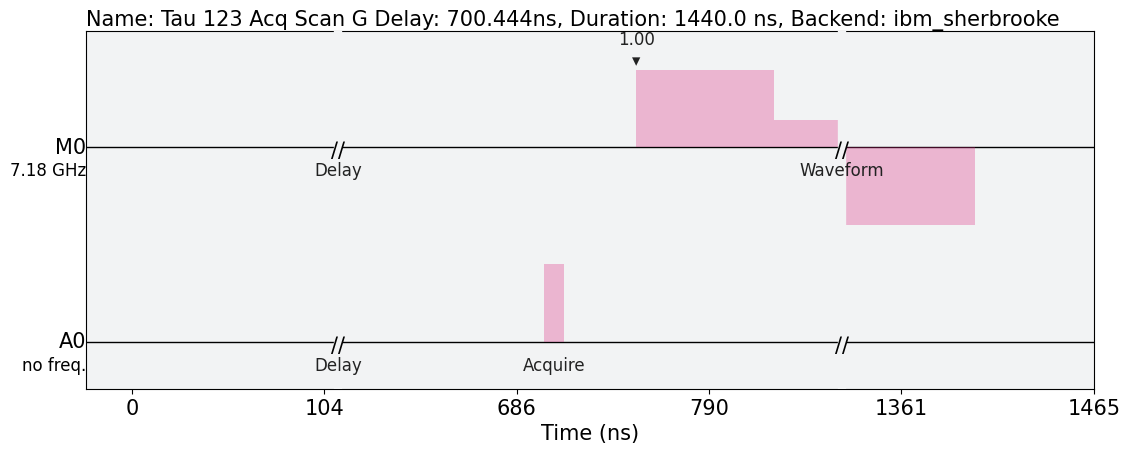

In [7]:
# Making Experiments

tau_1_exps_g = []
tau_1_exp_g_circs = []
tau_1_exps_e = []
tau_1_exp_e_circs = []

for acq_delay_us in acq_delay_linspace_us:
    acq_delay_dt = get_dt_from(acq_delay_us, dt)
    acq_delay_ns = np.round(acq_delay_us/ns, 3)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Tau 123 Acq Scan G Delay: {acq_delay_ns}ns',
    ) as tau_1_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(tau_123_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    tau_1_exps_g.append(tau_1_sched_g)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], tau_1_sched_g)
    tau_1_exp_g_circs.append(circ)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Tau 123 Acq Scan E Delay: {acq_delay_ns}ns',
    ) as tau_1_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(tau_123_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            acq_dur_dt,
            qubit,
            pulse.MemorySlot(qubit),
        )
    tau_1_exps_e.append(tau_1_sched_e)
    circ = QuantumCircuit(1,1)
    circ.measure(0,0)
    circ.add_calibration('measure', [0], tau_1_sched_e)
    tau_1_exp_e_circs.append(circ)

print(len(tau_1_exps_g))
print(len(tau_1_exps_e))
print(len(tau_1_exp_g_circs))
print(len(tau_1_exp_e_circs))

tau_1_exps_g[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

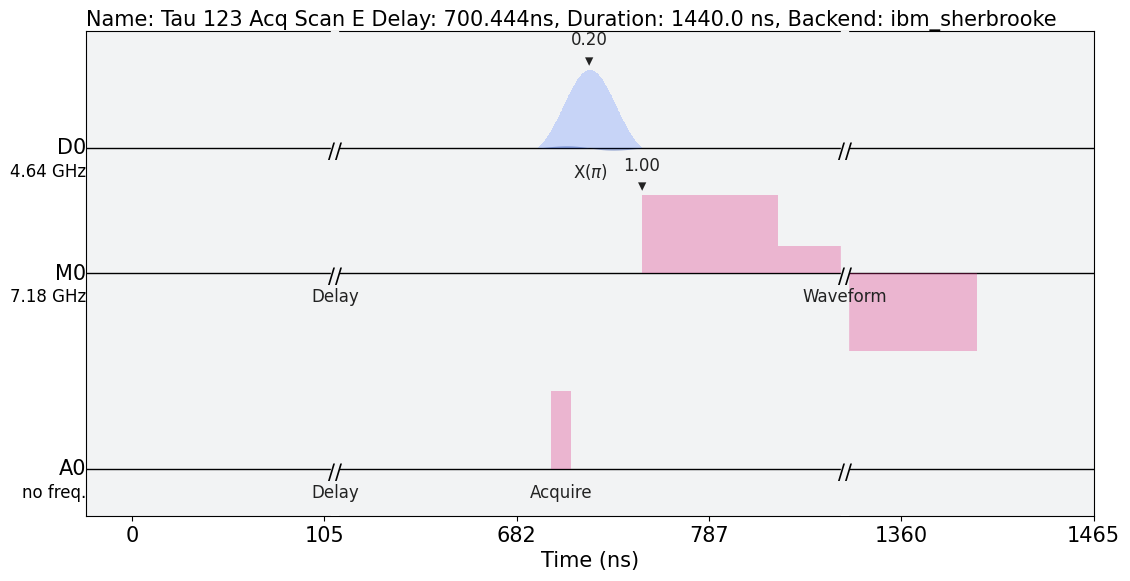

In [8]:
tau_1_exps_e[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

68


68


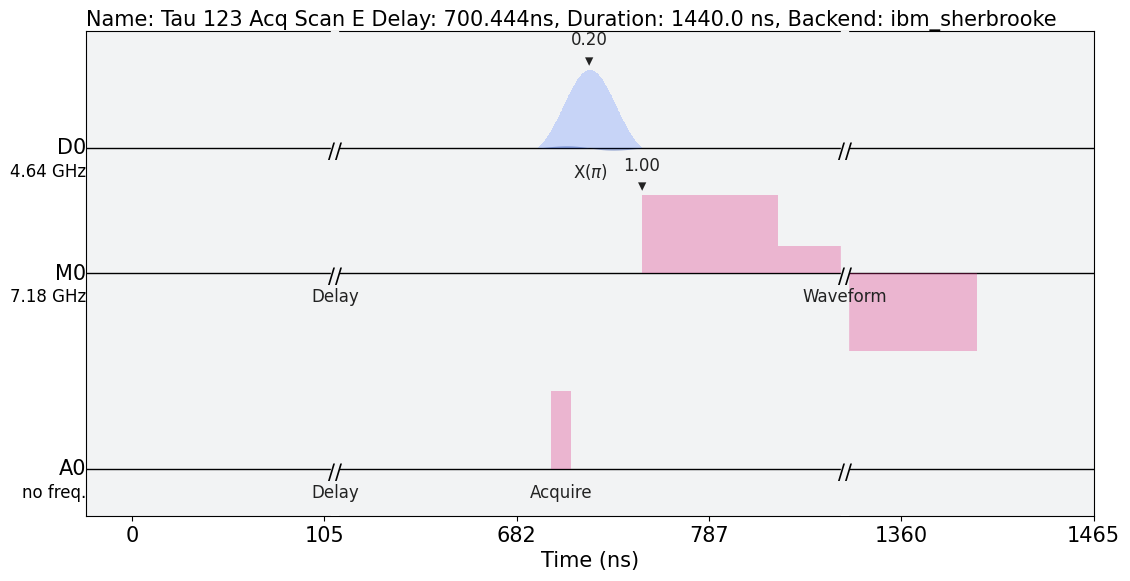

In [9]:
from utils import acquisition_checker

total_job = tau_1_exps_g + tau_1_exps_e
total_job_circs = tau_1_exp_g_circs + tau_1_exp_e_circs
print(len(total_job_circs))

acquisition_checker(total_job, backend)
print(len(total_job))

num_shots = 4096
rep_delay = 1.0 * us

total_job[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [16]:
# Running total_job

job_experiment = backend.run(total_job_circs, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_79822/2926945361.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment = backend.run(total_job_circs,


<RuntimeJob('ctrw3v74gzyg008zykb0', 'circuit-runner')>


In [17]:
# Running total_job alt

job_experiment_2 = backend.run(total_job_circs, 
                            meas_level=0, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay,
                            init_qubits=True)

print(job_experiment_2)

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_79822/4053752009.py:3: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_experiment_2 = backend.run(total_job_circs,


<RuntimeJob('ctrw50w4gjh0008q0df0', 'circuit-runner')>


In [10]:
job_0 = service.job('ctrw50w4gjh0008q0df0')
job_1 = service.job('ctrw3v74gzyg008zykb0')

In [11]:
results = job_1.result()

In [12]:
results_data = results.to_dict()

In [13]:
actual_results = results_data["results"]

In [14]:
big_list_res = []

for res_obj in actual_results:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_res.append(temp)

big_array_res = np.array(big_list_res)

print(big_array_res.shape)

(68, 4096, 2)


In [15]:
big_array_res_complex = big_array_res[:,:,0] + 1.0j * big_array_res[:,:,1]
big_array_res_g = big_array_res_complex[:34]
big_array_res_e = big_array_res_complex[34:]
print(big_array_res_e.shape)

(34, 4096)


In [16]:
# Measure Fidelities of G/E by themselves
import copy
from utils import get_fidelity

big_fidelity, big_sep_fidelity = get_fidelity(copy.deepcopy(big_array_res_g), copy.deepcopy(big_array_res_e))
print(big_fidelity.shape)
print(big_sep_fidelity.shape)

(34,)
(34,)


In [17]:
print(np.max(big_fidelity))
print(np.max(big_sep_fidelity))

0.979736328125
0.9892943081418628


In [18]:
big_pf = -np.log10(1. - big_fidelity)
big_sep_pf = -np.log10(1. - big_sep_fidelity)

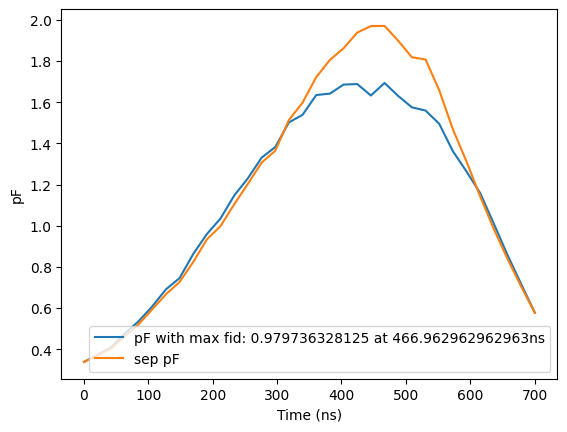

In [19]:
plt.plot(acq_delay_linspace/ns, big_pf, label=f'pF with max fid: {np.max(big_fidelity)} at {acq_delay_linspace[np.argmax(big_fidelity)]/ns}ns')
plt.plot(acq_delay_linspace/ns, big_sep_pf, label=f'sep pF')
plt.xlabel('Time (ns)')
plt.ylabel('pF')
plt.legend()
plt.show()

In [20]:
mean_g = np.mean(big_array_res_g, axis=1)
mean_e = np.mean(big_array_res_e, axis=1)

angle = 0.5 * (np.unwrap(np.angle(mean_g)) + np.unwrap(np.angle(mean_e))) - 0.5 * np.pi
rot_g = mean_g * np.exp(-1.0j * angle)
rot_e = mean_e * np.exp(-1.0j * angle)

print(rot_g.shape)

(34,)


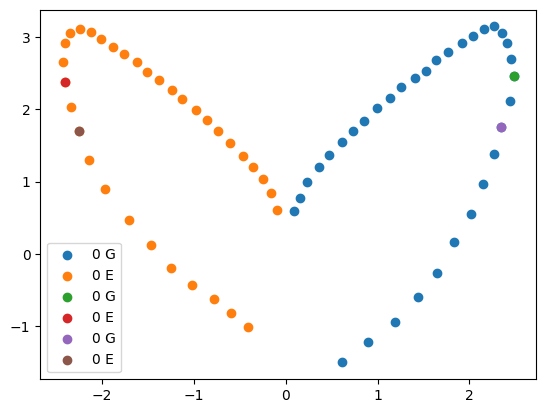

In [21]:
scale_factor = 1.0

plt.scatter(rot_g.real, rot_g.imag * scale_factor, label='0 G')
plt.scatter(rot_e.real, rot_e.imag * scale_factor, label='0 E')
plt.scatter(rot_g[np.argmax(big_fidelity)].real, rot_g[np.argmax(big_fidelity)].imag * scale_factor, label='0 G')
plt.scatter(rot_e[np.argmax(big_fidelity)].real, rot_e[np.argmax(big_fidelity)].imag * scale_factor, label='0 E') 
plt.scatter(rot_g[np.argmin(np.abs(acq_delay_linspace/ns - 520))].real, rot_g[np.argmin(np.abs(acq_delay_linspace/ns - 520))].imag * scale_factor, label='0 G')
plt.scatter(rot_e[np.argmin(np.abs(acq_delay_linspace/ns - 520))].real, rot_e[np.argmin(np.abs(acq_delay_linspace/ns - 520))].imag * scale_factor, label='0 E') 
plt.legend()
# plt.xlim(left=-10., right=10.)
plt.show()

In [22]:
# Processing meas_level=0 results

results_0 = job_0.result()

In [23]:
print(results_0.to_dict().keys())

dict_keys(['backend_name', 'backend_version', 'date', 'header', 'qobj_id', 'job_id', 'status', 'success', 'results', 'execution_id', 'time_taken', 'error'])


In [24]:
zero_results = results_0.to_dict()["results"]

In [32]:
big_list_res_zero = []

print(zero_results[0])

for res_obj in zero_results:
    temp = res_obj["data"]["memory"]
    temp = np.array(temp) * scale_factor
    temp = temp.squeeze()
    big_list_res_zero.append(temp)

big_array_res_zero = np.array(big_list_res_zero)

print(big_array_res_zero.shape)

{'shots': 4096, 'success': True, 'data': {'counts': {'0x0': 3044, '0x1': 1052}}, 'meas_level': 2, 'header': {'qubit_labels': [['q', 0]], 'n_qubits': 1, 'qreg_sizes': [['q', 1]], 'clbit_labels': [['c', 0]], 'memory_slots': 1, 'creg_sizes': [['c', 1]], 'name': 'circuit-232', 'global_phase': 0, 'metadata': {}}, 'status': 'done', 'meas_return': 'avg'}


KeyError: 'memory'